# The complexity of Generative adversarial network loss surface

This notebook recreates the experiments in the eponymous paper. Most of the work revolves around solving a certain quartic numerically, correctly choosing its roots and applying numerical quadrature on its solutions.

In [59]:
%load_ext autoreload
%autoreload 2

from functools import partial
import os 
import pickle as pkl
import sys

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns
from tqdm import tqdm 

sys.path.append("..")
from rmt.complexity import theta, in_integration_domain
from rmt.constants import b_constants, univariate_gaussian_variances, complexity_constant, integration_region
from rmt.coulomb import log_complexity_exponent, log_complexity_exponent_index, log_determinant
from rmt.spectrum import density, support
from rmt.empirical import sample_spectra, sample_spectrum, mc_log_determinant
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
figsize = (5, 5)

Ignoring warnings isn't great practice, but they spam the output here, particularly later on when using parallel processing.

In [61]:
import warnings
warnings.filterwarnings('ignore')

## Limiting spectral density

Find numerically the LSD of $$H = bM + b_1\left(\begin{array}{cc} M_1 & 0 \\ 0 & 0\end{array}\right) - x_1\left(\begin{array}{cc} I & 0 \\ 0 & 0\end{array}\right)$$ and compre with generated data from finite matrices.

Let's try with a generic set of parameters.

In [84]:
def compare_spectra(x1, kappa, b, b1, N):
    lsd = partial(density, x1=x1, kappa=kappa, b=b, b1=b1)
    spectrum = np.concatenate(sample_spectra(n_samples=100, x1=x1, kappa=kappa, b=b, b1=b1, dimension=N))
    plt.hist(spectrum, density=True, label="{}x{} \n matrices".format(N, N),
                color="darkblue", bins=30);

    z = np.linspace(-3-x1*b, 2*b, 1000)
    lims = support(x1, b, b1)
    z = np.linspace(lims[0], lims[1], 1000)
    d = np.array([lsd(zz) for zz in z])
    plt.plot(z, d, label="LSD", c='r');
    plt.legend(fontsize=15, loc="upper right")
    xticks = plt.xticks(fontsize=15)
    yticks = plt.yticks(fontsize=15)

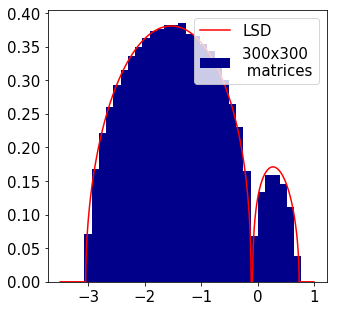

In [85]:
x1=1.5
kappa=0.9
b=1
b1=0.5
N = 300

plt.figure(figsize=figsize)
compare_spectra(x1, kappa, b, b1, N)
plt.savefig("../figures/spectrum_touching.pdf")

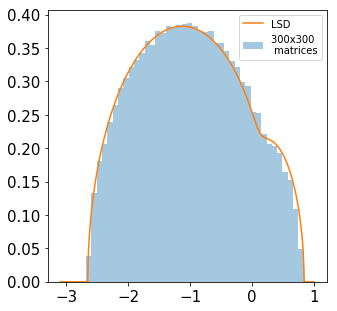

In [212]:
plt.figure(figsize=figsize)

x1=1.1
compare_spectra(x1, kappa, b, b1, N)
plt.savefig("../figures/spectrum_merged.pdf")

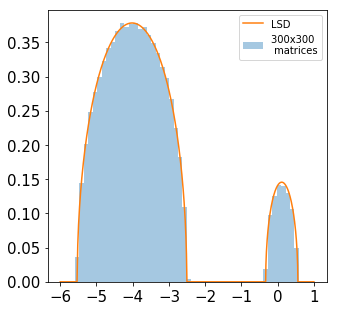

In [213]:
plt.figure(figsize=figsize)

x1=4
compare_spectra(x1, kappa, b, b1, N)
plt.savefig("../figures/spectrum_separate.pdf")

## Exponent function 

We use the Coulomb gas approximation to compute the log expected determinant of the Hessain (H) to leading order.

$$H = bM + b_1\left(\begin{array}{cc} M_1 & 0 \\ 0 & 0\end{array}\right) - x_1\left(\begin{array}{cc} I & 0 \\ 0 & 0\end{array}\right)$$

$$\mathbb{E} |\det H - x| \approx \exp\left(N\int\log|\lambda - x| d\mu_{eq}(\lambda)\right)$$

$$C_N \approx K_N \iint_B dxdx_1  \exp\left\{-N\left(\frac{x^2}{2s^2}+ \frac{x_1^2}{2s_1^2} - \int\log|\lambda - x| d\mu_{eq}(\lambda)\right)\right\}$$

We start by comparing the result of this approximation to numerical calculation of the expected log determinant using finite dimension matrix samples and Monte Carlo averaging.

In [24]:
p, q, sigma_z, kappa = 3, 3, 1., 0.9

x1 = np.linspace(-90, 90, 5)
x = np.linspace(-200, 200, 50)
N = 50

mc_det_vals = np.zeros((len(x1), len(x)))
det_vals = mc_det_vals.copy()

b, b1 = b_constants(p, q, sigma_z, kappa)

det = np.vectorize(partial(log_determinant, kappa=kappa, b=b, b1=b1))
mc_det = np.vectorize(partial(mc_log_determinant, b=b, b1=b1, kappa=kappa, n_samples=50, dimension=N))

for x1ind, x1_v in tqdm(enumerate(x1)):
    mc_det_vals[x1ind] = mc_det(x, x1_v)
    det_vals[x1ind] = det(x, x1_v)

5it [01:15, 15.20s/it]


In [10]:
def multiply_figsize(fs_minor, fs_major):
    return (fs_minor[0]*fs_major[0], fs_minor[1]*fs_major[1])

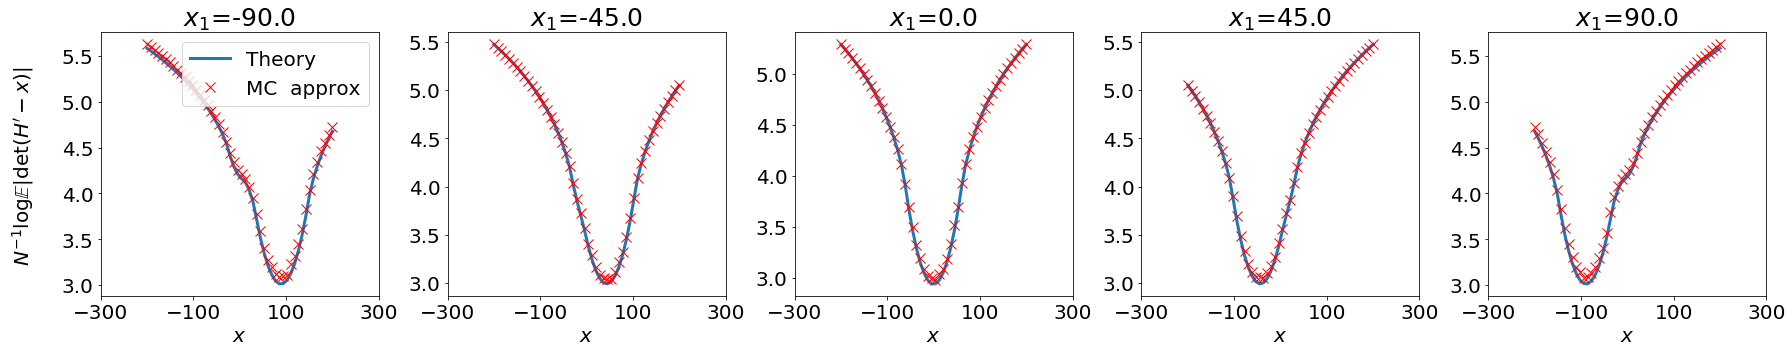

In [25]:
plt.figure(figsize=multiply_figsize(figsize, (5, 1)));
for x1ind, x1_v in enumerate(x1):
    plt.subplot(1, 5, x1ind+1);
    plt.plot(x, det_vals[x1ind], label="Theory", linewidth=3);

    plt.plot(x, mc_det_vals[x1ind], 'x', label="MC  approx", markersize=10, c='r');
    plt.xlabel('$x$', fontsize=20);
    plt.title('$x_1$={:.1f}'.format(x1_v), fontsize=25);
    xticks = plt.xticks(fontsize=20)
    plt.xticks(xticks[0][::2])
    yticks = plt.yticks(fontsize=20)
    if x1ind == 0:
        plt.ylabel("$N^{-1}\log\mathbb{E}|\det(H'-x)|$ \n", fontsize=20);
        plt.legend(fontsize=20, loc="upper right");

plt.tight_layout();
plt.savefig("../figures/numerical_coulomb_verification.pdf");

We get nice agreement for the Coulomb approximation, even at low $N$.

Now let's plot the exponent function in 2d and the marginals.

In [51]:
p, q, sigma_z, kappa = 3, 3, 1., 0.9

b, b1 = b_constants(p, q, sigma_z, kappa)
C = complexity_constant(p, q, sigma_z, kappa)
s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)

exp = np.vectorize(partial(log_complexity_exponent, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq))

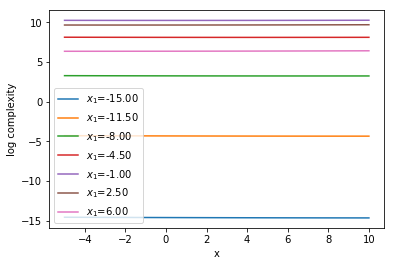

In [52]:
x1 = np.linspace(-15, 6, 7)
x = np.linspace(-5, 10, 20)

e = np.array([exp(x, x1v) for x1v in x1])

# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1);
for x1_val, es in zip(x1, e):
    plt.plot(x, es, label="$x_1$={:.2f}".format(x1_val));
    plt.xlabel("x");
    plt.ylabel("log complexity");
    # plt.subplot(1, 2, 2);
    # plt.plot(x, np.maximum.accumulate(e));
    # plt.xlabel("x");
    # plt.ylabel("rolling maximum log complexity");
    plt.legend();
plt.savefig("../figures/exponent_marginal_x.pdf")

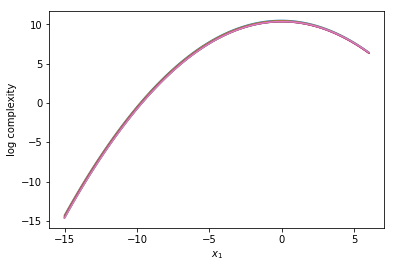

In [53]:
x = np.linspace(-25, 10, 7)
x1 = np.linspace(-15, 6, 100)

e = np.array([exp(xv, x1) for xv in x])

for x_val, es in zip(x, e):
    plt.plot(x1, es, label="$x$={:.2f}".format(x_val));
    plt.xlabel("$x_1$");
    plt.ylabel("log complexity");
    # plt.subplot(1, 2, 2);
    # plt.plot(x, np.maximum.accumulate(e));
    # plt.xlabel("x");
    # plt.ylabel("rolling maximum log complexity");
plt.savefig("../figures/exponent_marginal_x1.pdf")

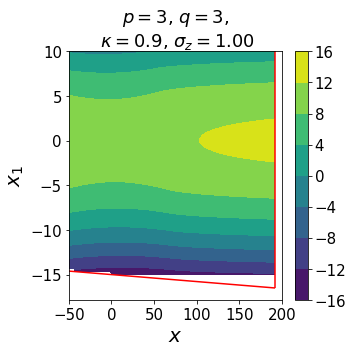

In [55]:
p = q = 3
kappa = 0.9
sigma_z = 1.
plt.figure(figsize=figsize);
x = np.linspace(-50, 200, 200)
x1 = np.linspace(-15, 10, 75)
x, x1 = np.meshgrid(x, x1)

b, b1 = b_constants(p, q, sigma_z, kappa)
C = complexity_constant(p, q, sigma_z, kappa)
s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)
exp = np.vectorize(partial(log_complexity_exponent, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq))

e = exp(x, x1)

P, Q, R = integration_region(5, 0.5, p, q)
in_domain = partial(in_integration_domain, P=P, Q=Q, R=R)

plot_vals = e.copy()
in_dom = in_domain(x, x1)
plot_vals[~in_dom] = np.nan
plt.contourf(x, x1, np.real(plot_vals))
cbar = plt.colorbar()
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=15)

plt.plot(x[x<P], R*x[x<P] + Q, c='r');
plt.vlines([P], [R*P+Q], [x1.max()], color='r');

plt.xlabel("$x$", fontsize=20);
plt.ylabel("$x_1$", fontsize=20);
plt.title("$p=${}, $q=${},\n $\kappa=${:.1f}, $\sigma_z=${:.2f}".format(p,q,kappa,sigma_z), fontsize=18);
xticks = plt.xticks(fontsize=15)
# plt.xticks(xticks[0][::2])
yticks = plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("../figures/exponent_in_domain.pdf");

In [56]:
uD, uG, theta_vals = theta(x, x1, np.real(e), p, q)

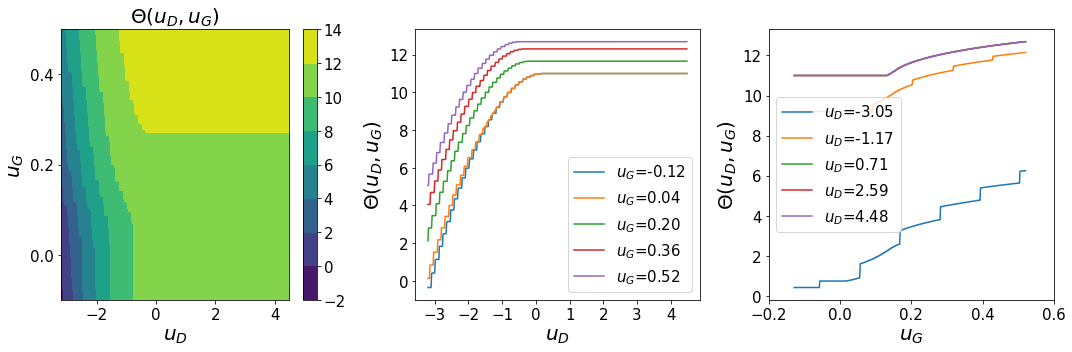

In [57]:
plt.figure(figsize=multiply_figsize(figsize, (3, 1)));

plt.subplot(1, 3, 1);
plt.contourf(uD, uG, theta_vals);
plt.title("$\Theta(u_D, u_G)$", fontsize=20);
plt.xlabel("$u_D$", fontsize=20);
plt.ylabel("$u_G$", fontsize=20);


xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
plt.yticks(yticks[0][::2])
plt.ylim([-.1, .5]);
cbar = plt.colorbar()
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=15)


plt.subplot(1, 3, 2);
for row_ind in np.linspace(10, uD.shape[0]-1, 5):
    row_ind = int(row_ind)
    plt.plot(uD[row_ind], theta_vals[row_ind], label="$u_G$={:.2f}".format(uG[row_ind, 0]));
plt.legend(fontsize=15);
plt.ylabel("$\Theta(u_D, u_G)$", fontsize=20);
plt.xlabel("$u_D$", fontsize=20);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)

plt.subplot(1, 3, 3);
for col_ind in np.linspace(10, uG.shape[1]-1, 5):
    col_ind = int(col_ind)
    plt.plot(uG[:, col_ind], theta_vals[:, col_ind], label="$u_D$={:.2f}".format(uD[0, col_ind]));
plt.legend(fontsize=15);
plt.ylabel("$\Theta(u_D, u_G)$", fontsize=20);
plt.xlabel("$u_G$", fontsize=20);
xticks = plt.xticks(fontsize=15)
plt.xticks(xticks[0][::2])
yticks = plt.yticks(fontsize=15)

plt.tight_layout();

plt.savefig("../figures/theta.pdf")

### Index specific complexity

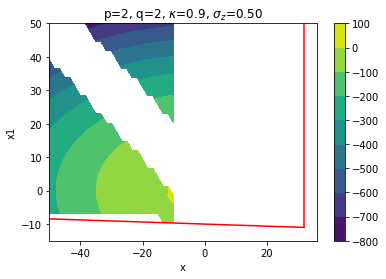

In [3]:
p = q = 3
kappa = 0.9
sigma_z = .5
kd, kg = 1, 1


b, b1 = b_constants(p, q, sigma_z, kappa)
max_x = np.sqrt(2 * (1 - kappa)) * b * 1.05


x = np.linspace(-50, max_x, 75)
x1 = np.linspace(-15, 50, 75)
x, x1 = np.meshgrid(x, x1)


C = complexity_constant(p, q, sigma_z, kappa)
s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)
exp = np.vectorize(partial(log_complexity_exponent_index, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq, kd=kd, kg=kg))

e = exp(x, x1)

P, Q, R = integration_region(5, 0.5, p, q)
in_domain = partial(in_integration_domain, P=P, Q=Q, R=R)

plot_vals = e.copy()
in_dom = in_domain(x, x1)
plot_vals[~in_dom] = np.nan
plt.contourf(x, x1, np.real(plot_vals))
plt.colorbar();

domain_boundary_x = np.linspace(np.min(x), max(np.max(x), P), 500)
plt.plot(domain_boundary_x, R*domain_boundary_x + Q, c='r');
plt.vlines([P], [R*P+Q], [x1.max()], color='r');

plt.xlabel("x");
plt.ylabel("x1");
plt.title("p={}, q={}, $\kappa$={:.1f}, $\sigma_z$={:.2f}".format(p,q,kappa,sigma_z));
plt.savefig("../figures/exponent_index_in_domain.pdf");

In [ ]:
uD, uG, theta_vals = theta(x, x1, np.real(e), p, q)

In [ ]:
plt.figure(figsize=(15, 5));

plt.subplot(1, 3, 1);
plt.contourf(uD, uG, theta_vals);
plt.colorbar();
plt.title("$\Theta(u_D, u_G)$");
plt.xlabel("$u_D$");
plt.ylabel("$u_G$");



plt.subplot(1, 3, 2);
for row_ind in np.linspace(10, uD.shape[0]-1, 10):
    row_ind = int(row_ind)
    plt.plot(uD[row_ind], theta_vals[row_ind], label="$u_G$={:.2f}".format(uG[row_ind, 0]));
plt.legend();
plt.ylabel("$\Theta(u_D, u_G)$");
plt.xlabel("$u_D$");

plt.subplot(1, 3, 3);
for col_ind in np.linspace(10, uG.shape[1]-1, 10):
    col_ind = int(col_ind)
    plt.plot(uG[:, col_ind], theta_vals[:, col_ind], label="$u_D$={:.2f}".format(uD[0, col_ind]));
plt.legend();
plt.ylabel("$\Theta(u_D, u_G)$");
plt.xlabel("$u_G$");

plt.tight_layout();

plt.savefig("../figures/theta_index.pdf")

#### Range indices

Load these results in from larger experiments.

In [30]:
def load_k_results(sigma):
    results_dir = "/work/jr19127/gan-loss-surfaces/rmt_results/rmt_vary_k_theta/sigma_{:.5f}".format(sigma)
    result_files = os.listdir(results_dir)

    results = []
    for fn in result_files:
        with open(os.path.join(results_dir, fn), "rb") as fin:
            results.append(pkl.load(fin))
    return results

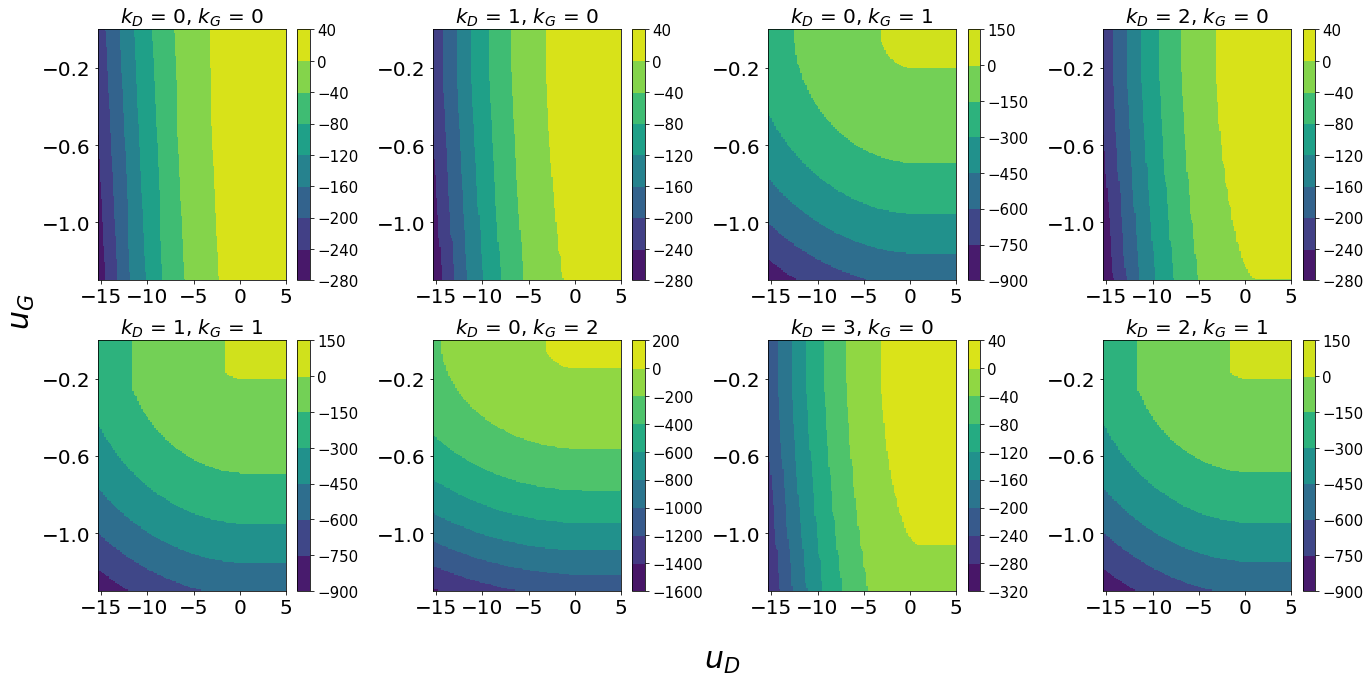

In [54]:
results = load_k_results(1)

fig = plt.figure(figsize=multiply_figsize(figsize, (4, 2)));

results = sorted(results, key=lambda r: r[0]+r[1])
for i, res in enumerate(results[:8]):
    plt.subplot(2, 4, i+1)
    plt.contourf(res[-2], res[-1], res[-3])
    xticks = plt.xticks(fontsize=20)
    yticks = plt.yticks(fontsize=20)
    plt.yticks(yticks[0][::2])
    plt.ylim([-1.3, 0.]) 

    cbar = plt.colorbar()
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=15)
    plt.title("$k_D$ = {}, $k_G$ = {}".format(res[0],res[1]), fontsize=20)
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, left=False, right=False, bottom=False)
plt.grid(False)
plt.xlabel('\n $u_D$', fontsize=30);
plt.ylabel('$u_G$ \n', fontsize=30);
plt.tight_layout();

plt.savefig("../figures/theta_indexs.pdf")

In [96]:
from numba import jit, njit

def fast_transform_k_data(results):
    kd_array = []
    kg_array = []
    for r in results:
        pos = r[-3] > 0
        kdarr = pos*r[0]
        kgarr = pos*r[1]
        kdarr = kdarr - (~pos)
        kgarr = kgarr - (~pos)
        kd_array.append(kdarr)
        kg_array.append(kgarr)
    kd_array = np.array(kd_array)
    kg_array = np.array(kg_array)
    kd_inds = np.max(kd_array, axis=0)
    kg_inds = np.max(kg_array, axis=0)
    return results[0][-2], results[0][-1], kd_inds, kg_inds
                    
def contour_plot_ks(kd_inds, kg_inds, uD, uG, lower_x=-4, lower_y=-1.5, zoom_x=(-4, 0), zoom_y=(-.5, 1),
                   kd_cmap_step=2, kg_cmap_step=2, zoom=False):
    plt.figure(figsize=multiply_figsize((10, 10), (2, 1) if zoom else (1, 1)))

    y_ind_min = np.min(np.argwhere(uD[0] > lower_x))
    x_ind_min = np.min(np.argwhere(uG[:, 0] > lower_y))
    ax = plt.subplot(1, 2 if zoom else 1, 1)

    kdcmap = [cm.get_cmap('inferno', 128)(i) for i in range(0, 128, kd_cmap_step)]
    kgcmap = [cm.get_cmap('viridis', 128)(i) for i in range(0, 128, kg_cmap_step)]
    cont1 = ax.contour(uDs[x_ind_min:, y_ind_min:], uGs[x_ind_min:, y_ind_min:], kd_inds[x_ind_min:, y_ind_min:], np.unique(np.abs(kd_inds))[::2], colors=kdcmap);
    cont2 = ax.contour(uDs[x_ind_min:, y_ind_min:], uGs[x_ind_min:, y_ind_min:], kg_inds[x_ind_min:, y_ind_min:], np.unique(np.abs(kg_inds))[::2], colors=kgcmap);
    cont1.clabel(fmt="%d", fontsize=15)
    cont2.clabel(fmt="%d", fontsize=15)

    ax.set_ylim([lower_y, 0.05]);
    
    ax.set_xlabel("$u_D$", fontsize=20);
    ax.set_ylabel("$u_G$", fontsize=20);
    xticks = plt.xticks(fontsize=20)
    yticks = plt.yticks(fontsize=20)
    plt.yticks(yticks[0][::2])

    if zoom:
        ax = plt.subplot(1, 2, 2)
    
#         ax.set_xlim(zoom_x)
#         ax.set_ylim(zoom_y)
        x_ind_max = np.max(np.argwhere(uD[0] < zoom_x[1]))
        x_ind_min = np.min(np.argwhere(uD[0] > zoom_x[0]))
        y_ind_max = np.max(np.argwhere(uG[:, 0] < zoom_y[1]))
        y_ind_min = np.min(np.argwhere(uG[:, 0] > zoom_y[0]))
        
        cont1 = ax.contour(uDs[x_ind_min:x_ind_max, y_ind_min:y_ind_max],
                           uGs[x_ind_min:x_ind_max, y_ind_min:y_ind_max],
                           kd_inds[x_ind_min:x_ind_max, y_ind_min:y_ind_max],
                           np.unique(kd_inds[x_ind_min:x_ind_max, y_ind_min:y_ind_max]),
                           colors=kdcmap);
        cont2 = ax.contour(uDs[x_ind_min:x_ind_max, y_ind_min:y_ind_max],
                       uGs[x_ind_min:x_ind_max, y_ind_min:y_ind_max],
                       kg_inds[x_ind_min:x_ind_max, y_ind_min:y_ind_max],
                       np.unique(kg_inds[x_ind_min:x_ind_max, y_ind_min:y_ind_max]),
                       colors=kgcmap);

        cont1.clabel(fmt="%d", fontsize=15);
        cont2.clabel(fmt="%d", fontsize=15);


        ax.set_xlabel("$u_D$", fontsize=20);
        xticks = plt.xticks(fontsize=20)
        plt.xticks(xticks[0][::2])
    plt.tight_layout();

In [71]:
results = load_k_results(1)
uDs = results[0][-2]
uGs = results[0][-1]
uD, uG, kd_inds, kg_inds = fast_transform_k_data(results)

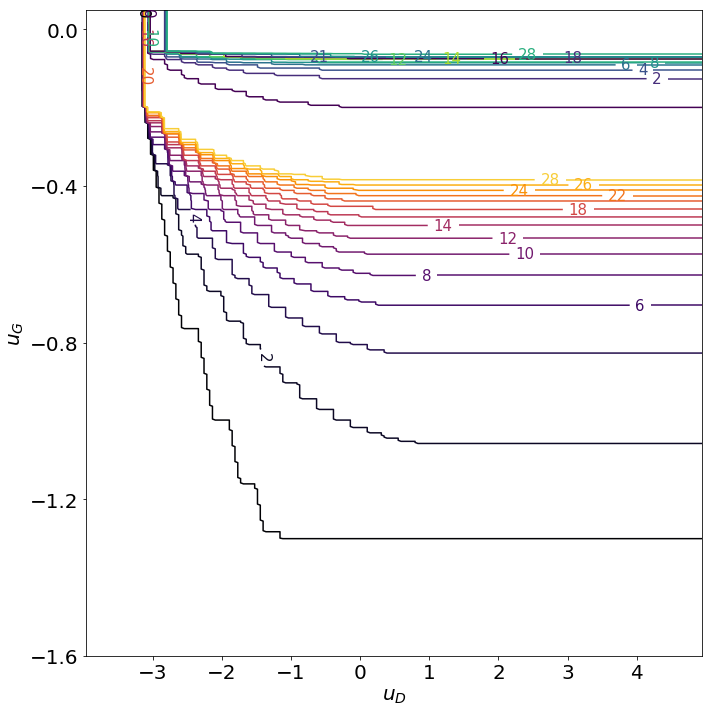

In [97]:
zoom_y = (-0.5, 0.5)
contour_plot_ks(kd_inds, kg_inds, uD, uG, zoom_y=zoom_y, kd_cmap_step=8, kg_cmap_step=16)
plt.savefig("../figures/kd_kg_strcture_contour.pdf");

Using -1 to represent no possible critical points works better with the interpolation for the plotting of these contours. For filled contour plots, it is much easier to visualise if we use `-np.inf`, as this is omitted from the contour, showing up the unfeasible regions as white.

In [104]:
def plot_filled_contour_ks(kd_inds, kg_inds, uD, uG, lower_x=-4, lower_y=-1.2):
    fig = plt.figure(figsize=multiply_figsize(figsize, (2, 1)))

    _kd_inds = kd_inds[:].astype(float)
    _kd_inds[kd_inds==-1] = -np.inf
    _kg_inds = kg_inds[:].astype(float)
    _kg_inds[kg_inds==-1] = -np.inf
    ax = plt.subplot(1, 2, 1)
    cont1 = ax.contourf(uDs, uGs, _kd_inds);

    ax.set_xlim([lower_x, np.max(uD)]);
    ax.set_ylim([lower_y, np.max(uG)]);
    ax.set_xlabel("$u_D$", fontsize=20);
    ax.set_ylabel("$u_G$", fontsize=20);
    ax.set_title("$k_D$", fontsize=20)
    xticks = plt.xticks(fontsize=20)
    yticks = plt.yticks(fontsize=20)
    plt.yticks(yticks[0][::2])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.15)

    cbar = fig.colorbar(cont1, cax=cax, orientation='vertical');
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=15)

    ax = plt.subplot(1, 2, 2)

    cont2 = ax.contourf(uDs, uGs, _kg_inds);
    ax.set_xlim([lower_x, np.max(uD)]);
    ax.set_ylim([lower_y, np.max(uG)]);
    
    ax.set_xlabel("$u_D$", fontsize=20);
    ax.set_title("$k_G$", fontsize=20)
    xticks = plt.xticks(fontsize=20)
    yticks = plt.yticks(fontsize=20)
    plt.yticks(yticks[0][::2])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.15)

    cbar = fig.colorbar(cont2, cax=cax, orientation='vertical');
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=15)
    plt.tight_layout()


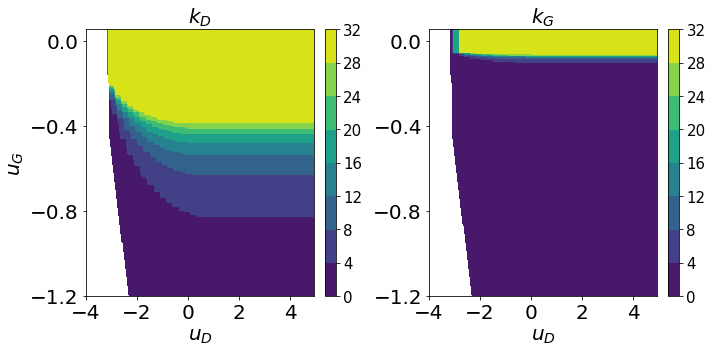

In [105]:
plot_filled_contour_ks(kd_inds, kg_inds, uD, uG)
plt.savefig("../figures/kd_kg_filled_contours.pdf");